In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm
import numba as nb

from scipy.sparse import coo_matrix
from scipy.linalg import block_diag, pinvh

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# np.random.seed(1001)
# random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1000
signal_to_noise = 4

L = 5


ranks = np.array([10, 7, 5, 4, 1])
rank = ranks.sum()

nsamples = rank * 3
rank, nsamples

(27, 81)

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1000.0
level=1, num_groups=3, mean_size=333.3
level=2, num_groups=7, mean_size=142.9
level=3, num_groups=16, mean_size=62.5
level=4, num_groups=1000, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([   0, 1000]),
 array([   0,  250,  500, 1000]),
 array([   0,  125,  250,  375,  500,  750,  875, 1000]),
 array([   0,   62,  125,  187,  250,  312,  375,  437,  500,  562,  625,
         687,  750,  812,  875,  937, 1000])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=25.735502424113147, noise_var=6.2804102536327004
SNR=4.097742246890205, signal_to_noise=4


In [7]:
true_D_noise.min(), true_D_noise.max()

(0.005053450908673237, 12.856281049246242)

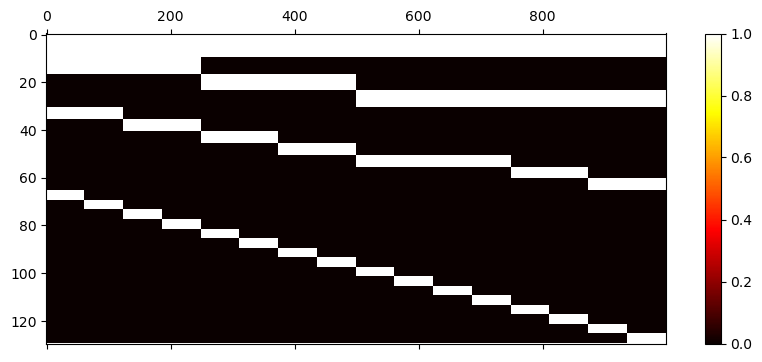

(1000, 130)


In [8]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [9]:
true_sparse_F.shape

(1000, 130)

In [10]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [11]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [12]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]
v = np.random.randn(n)

In [13]:
true_mlr.construct_sparse_format()
hat_x = mfm.iterative_refinement(ranks, v[:, np.newaxis], F_Lm1, D, F_hpart, eps=1e-12, max_iter=50)
np.linalg.norm(hat_x - np.linalg.inv(true_mlr.matrix()) @ v[:, np.newaxis])

3.727081512000914e-13

In [14]:
mfm_Sigma = mfm.MFModel(F=F_Lm1, D=D, hpart=F_hpart, ranks=ranks)

assert true_sparse_F.shape[1] == mfm_Sigma.num_factors()

# Linear system solve, matvec

In [15]:
for _ in range(50):
    v = np.random.randn(n, 1)
    # linear system solve
    hat_x = mfm_Sigma.solve(v, eps=1e-12, max_iter=50)
    reldiff = np.linalg.norm(hat_x - np.linalg.solve(true_mlr.matrix(),v)) / np.linalg.norm(v)
    # print(f"solve {reldiff=}")
    assert reldiff < 1e-12

    # matvec
    Av = mfm_Sigma.matvec(v)
    reldiff = np.linalg.norm(Av - true_mlr.matvec(v)) / np.linalg.norm(v)
    assert reldiff < 1e-12, print(f"matvec {reldiff=}")


    # Fz
    z = np.random.randn(mfm_Sigma.num_factors(), 1)
    Fz = mfm_Sigma.F_matvec(z)
    reldiff = np.linalg.norm(Fz - true_sparse_F @ z) / np.linalg.norm(z)
    assert reldiff < 1e-12, print(f"matvec {reldiff=}")


print("PASSED")

PASSED


# Test $\mathop{diag}(\Sigma)$

In [16]:
d1 = np.diag(true_mlr.matrix())
d2 = mfm_Sigma.diag()
assert np.allclose(d1, d2)

print("PASSED")

PASSED


# Test $\Sigma$

In [17]:
assert np.allclose(true_mlr.matrix(), mfm_Sigma.matrix())

print("PASSED")

PASSED


In [18]:
def estimate_diagonal(n, A_matvec, num_samples=10000):
    diagonal_estimates = np.zeros((n, 1))
    qk = 0
    for _ in range(num_samples):
        zk = np.random.randn(n, 1)
        # zk = np.random.choice([-1, 1], size=n) 
        Azk = A_matvec(zk)
        diagonal_estimates += zk * Azk
        qk = qk + (zk * zk)
    # assert Azk.shape == diagonal_estimates.shape
    return diagonal_estimates / qk

# Example usage with a mock matrix-vector product function
A = np.random.randn(100, 100)
A = A @ A.T


In [19]:
for num_samples in [10, 100, 1000, 10000, 100000, 1000000]:
    estimated_diag = estimate_diagonal(100, lambda x: A @ x, num_samples=num_samples)
    print(f"{num_samples=}, rel_diff={mf.rel_diff(np.diag(A), estimated_diag.flatten()):.6f}")

num_samples=10, rel_diff=0.341785
num_samples=100, rel_diff=0.102837
num_samples=1000, rel_diff=0.031776
num_samples=10000, rel_diff=0.008836
num_samples=100000, rel_diff=0.002823
num_samples=1000000, rel_diff=0.000877


In [20]:
for num_samples in [10, 100, 1000, 10000]:
    estimated_diag = estimate_diagonal(n, lambda x: mfm_Sigma.matvec(x), num_samples=num_samples)
    print(f"{num_samples=}, rel_diff={mf.rel_diff(mfm_Sigma.diag(), estimated_diag.flatten()):.6f}")

num_samples=10, rel_diff=1.258355
num_samples=100, rel_diff=0.357383
num_samples=1000, rel_diff=0.105521
num_samples=10000, rel_diff=0.034781


# EM elements

In [21]:
num_sparsities = row_selectors.size - 1
tilde_F0 = mf.convert_compressed_to_sparse(F_Lm1, F_hpart, ranks[:-1])
D1 = np.zeros(n)
# for si in tqdm(range(num_sparsities)):
for si in range(num_sparsities):
    si_col = mfm.group_to_indices(si_groups[si], part_sizes, ranks)
    tilde_F_ci = true_sparse_F[:, si_col]
    assert np.allclose(tilde_F_ci, mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[si]))

print("PASSED")

PASSED


In [22]:
assert np.allclose(mfm.perm_hat_Sigma(F_Lm1, D, F_hpart, ranks), mfm.perm_hat_Sigma_sp(true_sparse_F, D))
print("PASSED")

PASSED


In [23]:
E = np.random.randn(n, nsamples)
E1 = np.diag(np.sqrt(true_D_noise)) @ E
E2 = np.sqrt(true_D_noise)[:, None] * E

assert np.allclose(E1, E2)

In [24]:
# C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
C = mfm.sample_data(nsamples, mfm_Sigma)

Z = (C - C.mean(axis=1, keepdims=True))[F_hpart["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[mfm_Sigma.pi_inv, :][:, mfm_Sigma.pi_inv]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

# True model loglikelihoods

In [25]:
true_Sigma = mfm.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_train_obj = mfm.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
exp_true_ll = mfm.exp_true_loglikelihood_value(true_Sigma)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_ll}")

TR: train ll=-2407.671040936053, exp ll=-2415.9574935684636


In [26]:
mfm_Sigma.init_FD(ranks, F_hpart, init_type="Y", Y=Y)
F0, D0 = mfm_Sigma.F, mfm_Sigma.D


permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}

# Test $\log \det \Sigma$

In [27]:
for t in range(10):
    if t == 0:
        mfm_Sigma.init_FD(ranks, F_hpart, init_type="Y", Y=Y)
        F0, D0 = mfm_Sigma.F, mfm_Sigma.D
    else:
        F0, D0 = np.random.randn(mfm_Sigma.F.shape[0], mfm_Sigma.F.shape[1]), np.random.rand(n) + 1e-2
    Sigma = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    (sign, logabsdet) = np.linalg.slogdet(Sigma)
    assert sign == 1, print(sign, logabsdet, np.linalg.det(Sigma))

    num_factors = mfm_Sigma.num_factors()
    rescaled_sparse_F = mf.convert_compressed_to_sparse(np.power(D0, -0.5)[:, np.newaxis] * F0, 
                                                F_hpart, 
                                                ranks[:-1])
    sigmas = scipy.sparse.linalg.svds( rescaled_sparse_F, k=num_factors-1, return_singular_vectors=False, which='LM')
    last_sigma = scipy.sparse.linalg.svds(rescaled_sparse_F, k=1, return_singular_vectors=False, which='SM')

    logdet = np.log(D0).sum() + np.log(sigmas**2 + 1).sum() + np.log(last_sigma**2 + 1).sum()

    assert np.allclose(logdet, logabsdet)

print("PASSED")

PASSED


In [28]:
np.diag(unpermuted_A).min(), np.diag(unpermuted_A).max(), true_D_noise.min(), true_D_noise.max()

(8.32788731810275, 73.2325525119172, 0.005053450908673237, 12.856281049246242)

In [29]:
loglikelihoods = [-np.inf]
N = Y.shape[0]
eps = 1e-12
for t in range(50):
    obj1 = mfm.fast_loglikelihood_value(F0, D0, Y, ranks, permuted_F_hpart, mfm_Sigma.num_factors())

    Sigma0 = mfm.perm_hat_Sigma(F0, D0, permuted_F_hpart, ranks)
    lu, piv = scipy.linalg.lu_factor(Sigma0)
    obj2 = mfm.loglikelihood_value(Sigma0, lu, piv, Y)
    # assert np.allclose(obj1, obj2), print(obj1, obj2)
    
    loglikelihoods += [obj1]

    F1 = mfm.fast_EM_get_F(F0, D0, Y, ranks, permuted_F_hpart, row_selectors, si_groups)
    F1_slow = mfm.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, permuted_F_hpart, row_selectors, si_groups)
    assert mf.rel_diff(F1, F1_slow) < 1e-8, print(mf.rel_diff(F1, F1_slow))
    D1 = mfm.fast_EM_get_D(F0, D0, F1, Y, ranks, permuted_F_hpart, row_selectors, si_groups)
    D1_slow = mfm.EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, permuted_F_hpart, row_selectors, si_groups)
    assert mf.rel_diff(D1, D1_slow) < 1e-8, print(mf.rel_diff(D1, D1_slow))
    F0, D0 = F1, D1
    assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]
    if t % 10 == 0:
        print(f"{t=}, {obj1=}, {D1.min()=}, {D1.max()=}, {mf.rel_diff(F1, F1_slow)}, {mf.rel_diff(D1, D1_slow)}")
    if loglikelihoods[-1] - loglikelihoods[-2] < eps * abs(loglikelihoods[-2]):
        print(f"terminating at {t=}")
        break
print(f"{t=}, {obj1=}")

print("PASSED")

t=0, obj1=-50443.228232902235, D1.min()=0.07137589125387073, D1.max()=31.121930912730953, 4.26111818567658e-12, 7.384067989914046e-13
t=10, obj1=-2372.070751735922, D1.min()=0.133544594052884, D1.max()=15.358002132678578, 1.6354624224335798e-12, 1.0858538417134101e-12
t=20, obj1=-2307.942407678821, D1.min()=0.07358611219035116, D1.max()=13.148674051663706, 9.599082641794116e-13, 9.659345672521745e-13
t=30, obj1=-2276.9947344104417, D1.min()=0.043559944777258844, D1.max()=12.440819198225867, 5.844390772913946e-13, 4.738909535117699e-13
t=40, obj1=-2263.0991864447606, D1.min()=0.03161829588172039, D1.max()=12.509977192305737, 7.155335028571672e-13, 6.416418297354894e-13
t=49, obj1=-2254.5991936544815
PASSED


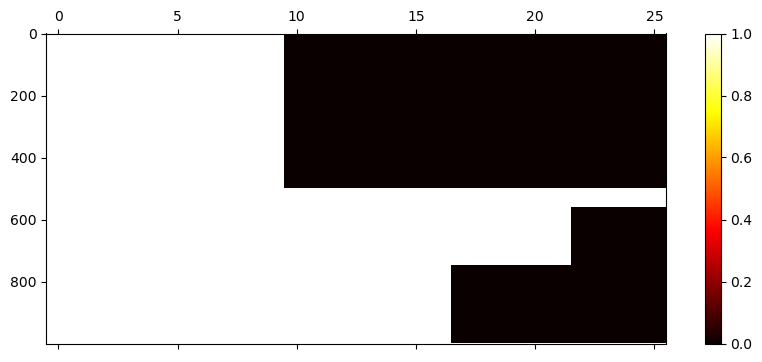

In [30]:
tilde_F_ci = mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[8])
plt.figure(figsize=(10, 4)) 
plt.matshow(tilde_F_ci!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

In [31]:
import numba as nb

In [33]:
nb.njit(parallel=True)
def nb_get_sparse_F_si_col_sparsity(F_compressed, ranks, F_hpart, group):
    res = np.zeros(F_compressed.shape)
    for level in nb.prange(len(group)):
        gi = group[level]
        r1, r2 = F_hpart["lk"][level][gi], F_hpart["lk"][level][gi+1]
        res[r1:r2, ranks[:level].sum() : ranks[:level+1].sum()] = F_compressed[r1:r2, ranks[:level].sum() : ranks[:level+1].sum()]
    return res


In [37]:
%timeit nb_get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[si])

73.9 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [36]:
%timeit mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[si])

73.8 µs ± 417 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
